In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\bayar\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
train = pd.read_csv('application_train.csv')
test = pd.read_csv('application_test.csv')
previous = pd.read_csv('previous_application.csv')
installments = pd.read_csv('installments_payments.csv')
pos = pd.read_csv('POS_CASH_balance.csv')
cc_bal = pd.read_csv('credit_card_balance.csv')

bureau = pd.read_csv('bureau.csv')
bureau_balance = pd.read_csv('bureau_balance.csv')

#dataset = train.append(test, sort = False)
#/tmp/ipykernel_20/2083752303.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  #dataset = train.append(test, sort = False)

In [5]:
dataset = train.append(test, sort = False)
#/tmp/ipykernel_20/2083752303.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  #dataset = train.append(test, sort = False)

C:\Users\bayar\AppData\Local\Temp\ipykernel_10028\1883614750.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataset = train.append(test, sort = False)


<AxesSubplot:xlabel='CODE_GENDER', ylabel='count'>

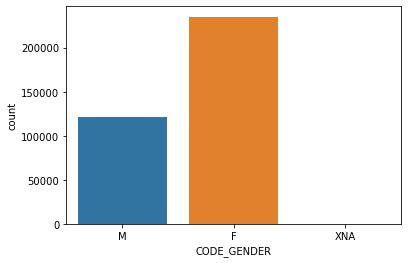

In [6]:
sns.countplot(data = dataset, x = 'CODE_GENDER')

In [8]:
#So women feature more often in the dataset. We also have a few values here that seem to be missing, which we will likely simply assign to be women because of their abundance in this dataset.

<AxesSubplot:xlabel='TARGET', ylabel='count'>

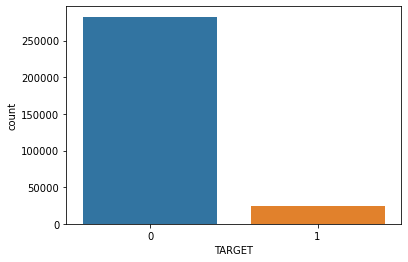

In [7]:
sns.countplot(data = train, x = 'TARGET')

In [9]:
#And we have an imbalanced classification problem, with our minority dataset being about one tenth the size of the majority. We will look into this in more detail later.

C:\Users\bayar\anaconda3\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


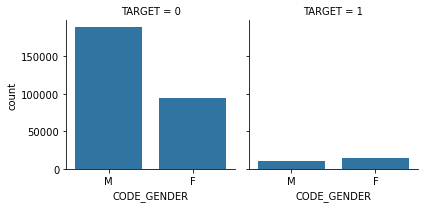

In [10]:
g = sns.FacetGrid(train, col = 'TARGET')
g.map(sns.countplot, 'CODE_GENDER')
#sns.catplot(data = train, col = 'TARGET', x = 'CODE_GENDER', kind = 'count')

In [11]:
#Notice that although men are only about half as many in number (overall), there are roughly as many men as women who are having payment difficulties. This suggests that males are more likely to have payment difficulties than women are.

C:\Users\bayar\anaconda3\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


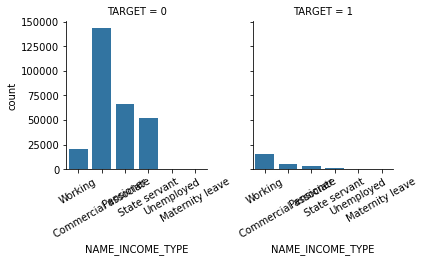

In [12]:
#sns.catplot(data = train, col = 'TARGET', x = 'NAME_INCOME_TYPE', kind = 'count')
g = sns.FacetGrid(data = train, col = 'TARGET')
g.map(sns.countplot, 'NAME_INCOME_TYPE')
g.set_xticklabels(rotation = 30)

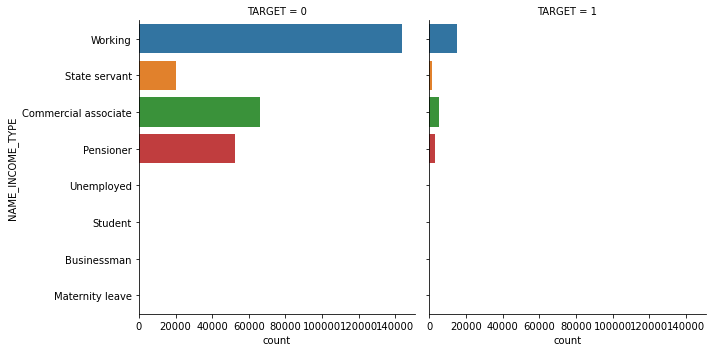

In [13]:
sns.catplot(data=train, col='TARGET', y='NAME_INCOME_TYPE', kind='count')

In [14]:
#There doesnt seem to be much of a difference between the distributions in either graph.

<AxesSubplot:xlabel='TARGET', ylabel='count'>

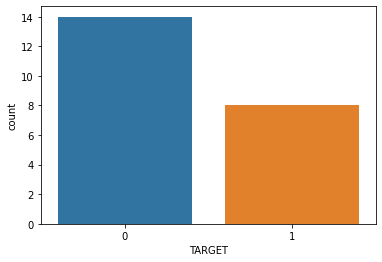

In [15]:
sns.countplot(data = train[train.NAME_INCOME_TYPE == 'Unemployed'], x = 'TARGET')

In [16]:
#More than a third of those who are unemployed in the dataset are having payment difficulties, which is a much higher ratio than the total dataset. This is not very surprising, since they are unemployed.


<AxesSubplot:xlabel='AMT_INCOME_TOTAL', ylabel='AMT_CREDIT'>

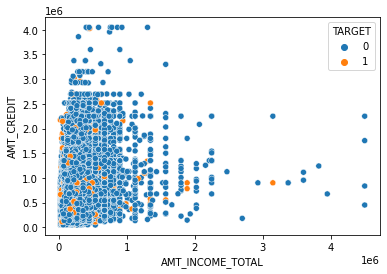

In [17]:
sns.scatterplot(x = 'AMT_INCOME_TOTAL', y = 'AMT_CREDIT', hue = 'TARGET', data = train[train.AMT_INCOME_TOTAL < 5000000])

In [19]:
#There doesnt seem to be a clear pattern emerging from this plot that would distinguish the clients with payment difficulties from those without. Its unlikely that the clients are simply borrowing too much and are thus unable to pay.

#Note here that this graph excludes about 4 entries in the dataset for the sake of a better graph, including one application that has payment difficulties despite only borrowing 500,000 with an income of about 10 million.


In [20]:
installments['DAYS_EARLY'] = (installments.DAYS_INSTALMENT - installments.DAYS_ENTRY_PAYMENT)

installments['DAYS_LATE'] = installments['DAYS_EARLY'].map(lambda x: x if x < 0 else 0)

In [21]:
pos['DPD_LEVELS'] = pos.SK_DPD_DEF.map(lambda days: (days+29)//30 if days < 121 else 5) 
cc_bal['DPD_LEVELS'] = cc_bal.SK_DPD_DEF.map(lambda days: (days+29)//30 if days < 121 else 5)

In [22]:
#Aggregating Data from Supplementary Tables

In [23]:
# With this mapping, if DPD = 0, then the level will be 0, if DPD is between 1 and 30, the level will be 1, and so on until 5.

In [24]:
previous = previous[previous.NAME_CONTRACT_STATUS != 'Canceled']

In [25]:
#For the bureau and bureau balance tables, there does not seem to be any guarantee that balance information will be available for any given record in bureau. For some SK_ID_CURR, there are in fact no entries at all in bureau_balance that correspond to entries in bureau.

In [26]:
bureau['HAS_OVERDUE'] = bureau.AMT_CREDIT_SUM_OVERDUE.map(lambda x: bool(x))
bureau['DPD_LEVEL'] = bureau.CREDIT_DAY_OVERDUE.map(lambda days: (days+29)//30 if days < 121 else 5)

In [27]:
previous['PREV_COUNT'] = 0
aggregate = previous[['PREV_COUNT', 'SK_ID_CURR']].groupby('SK_ID_CURR').count()
dataset = dataset.join(aggregate, on = 'SK_ID_CURR')
dataset.PREV_COUNT = dataset.PREV_COUNT.fillna(0)

previous['REJECT_COUNT'] = 0
aggregate = previous.loc[previous.NAME_CONTRACT_STATUS == 'Refused', ['REJECT_COUNT', 'SK_ID_CURR']].groupby('SK_ID_CURR').count()
dataset = dataset.join(aggregate, on = 'SK_ID_CURR')
dataset.REJECT_COUNT = dataset.REJECT_COUNT.fillna(0)

aggregate = previous[['AMT_CREDIT', 'SK_ID_CURR']].groupby('SK_ID_CURR').agg(['sum', 'mean'])
aggregate.columns = ['PREV_AMT_SUM', 'PREV_AMT_AVE']
dataset = dataset.join(aggregate, on = 'SK_ID_CURR')
dataset.PREV_AMT_SUM = dataset.PREV_AMT_SUM.fillna(0)
dataset.PREV_AMT_AVE = dataset.PREV_AMT_AVE.fillna(0)

aggregate = installments[['DAYS_EARLY', 'SK_ID_CURR']].groupby('SK_ID_CURR').sum()
dataset = dataset.join(aggregate, on = 'SK_ID_CURR')
dataset.DAYS_EARLY = dataset.DAYS_EARLY.fillna(0)

aggregate = installments[['DAYS_LATE', 'SK_ID_CURR']].groupby('SK_ID_CURR').agg(['sum', 'max'])
aggregate.columns = ['DAYS_LATE', 'MAX_DAYS_LATE']
dataset = dataset.join(aggregate, on = 'SK_ID_CURR')
dataset.DAYS_LATE = dataset.DAYS_LATE.fillna(0)
dataset.MAX_DAYS_LATE = dataset.MAX_DAYS_LATE.fillna(0)

aggregate = cc_bal[['DPD_LEVELS', 'SK_ID_CURR']].groupby('SK_ID_CURR').agg(['sum', 'max'])
aggregate.columns = ['CC_DPD_LEVELS', 'CC_MAX_DPD_LEVEL']
dataset = dataset.join(aggregate, on = 'SK_ID_CURR')
dataset.CC_DPD_LEVELS = dataset.CC_DPD_LEVELS.fillna(0)
dataset.CC_MAX_DPD_LEVEL = dataset.CC_MAX_DPD_LEVEL.fillna(0)

aggregate = pos[['DPD_LEVELS', 'SK_ID_CURR']].groupby('SK_ID_CURR').agg(['sum', 'max'])
aggregate.columns = ['POS_DPD_LEVELS', 'POS_MAX_DPD_LEVEL']
dataset = dataset.join(aggregate, on = 'SK_ID_CURR')
dataset.POS_DPD_LEVELS = dataset.POS_DPD_LEVELS.fillna(0)
dataset.POS_MAX_DPD_LEVEL = dataset.POS_MAX_DPD_LEVEL.fillna(0)

aggregate = bureau[['DPD_LEVEL', 'SK_ID_CURR']].groupby('SK_ID_CURR').agg(['sum', 'max'])
aggregate.columns = ['B_DPD_LEVELS', 'B_MAX_DPD_LEVEL']
dataset = dataset.join(aggregate, on = 'SK_ID_CURR')
dataset.B_DPD_LEVELS = dataset.B_DPD_LEVELS.fillna(0)
dataset.B_MAX_DPD_LEVEL = dataset.B_MAX_DPD_LEVEL.fillna(0)

aggregate = bureau[['HAS_OVERDUE', 'SK_ID_CURR']].groupby('SK_ID_CURR').max()
dataset = dataset.join(aggregate, on = 'SK_ID_CURR')
dataset.HAS_OVERDUE = dataset.HAS_OVERDUE.fillna(0)

In [28]:
#There is plenty of information left unused in the tables. Some examples of things I would have liked to explore are instances where the amount of credit for which the applicant applied is not the same as the amount of credit granted to the applicant from the previous_applications table and the number of times that the amortization schedule was changed from the installments_payments table.

In [29]:
missing = dataset.isna().sum()
missing.map(lambda x: x == 0).sum()

68

In [30]:
#There are quite a few columns here with missing data. Quite a few columns have the same number of missing entries. For example, AMT_REQ_CREDIT_BUREAU_HOUR, which counts the number of inquiries to the credit bureau about the client an hour before the application, shares the same number of missing values as AMT_REQ_CREDIT_BUREAU_DAY, as well as with the other columns indicating similar data. Since this is a count (of inquiries), we might simply assume that the entries ought to be 0. Similarly, there are columns that relate to the living conditions which have missing entries.

In [31]:
dataset['AMT_REQ_CREDIT_BUREAU_NA'] = dataset['AMT_REQ_CREDIT_BUREAU_HOUR'].isna() 
intervals = ['HOUR', 'DAY', 'WEEK', 'MON', 'QRT', 'YEAR']
for length in intervals:
    col_name = 'AMT_REQ_CREDIT_BUREAU_' + length
    dataset[col_name] = dataset[col_name].fillna(0)
    
col_base = ['APARTMENTS', 'BASEMENTAREA', 'COMMONAREA', 'ELEVATORS', 'ENTRANCES', 'FLOORSMAX', 'FLOORSMIN', 'LANDAREA', 
            'LIVINGAPARTMENTS', 'LIVINGAREA', 'NONLIVINGAREA', 'NONLIVINGAPARTMENTS', 'YEARS_BUILD', 'YEARS_BEGINEXPLUATATION']
mode_only = ['TOTALAREA', 'WALLSMATERIAL', 'HOUSETYPE', 'EMERGENCYSTATE', 'FONDKAPREMONT']
for col in col_base + mode_only:
    dataset[col + '_NA'] = dataset[col + '_MODE'].isna()
    dataset[col + '_MODE'] = dataset[col + '_MODE'].fillna(dataset[col+'_MODE'].mode()[0]) #fill with what?
for col in col_base:
    for agg in ['AVG', 'MEDI']:
        dataset.loc[:, col + '_' + agg] = dataset[col + '_' + agg].fillna(dataset[col+ '_' + agg].mean()) #fill with what?

# 1 missing entry, fill with median value because distribution is not normal
dataset['DAYS_LAST_PHONE_CHANGE'] = dataset['DAYS_LAST_PHONE_CHANGE'].fillna(dataset['DAYS_LAST_PHONE_CHANGE'].median()) 

#2280 missing entries, fill with mode: unaccomapnied
dataset.NAME_TYPE_SUITE = dataset.NAME_TYPE_SUITE.fillna('Unaccompanied')

In [32]:
#For the column specifying car age, we choose to use median instead of mean because there seems to be quite a few large outliers, causing the distribution to have a mean of 12 and a standard deviation of around 11.

C:\Users\bayar\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='OWN_CAR_AGE', ylabel='Density'>

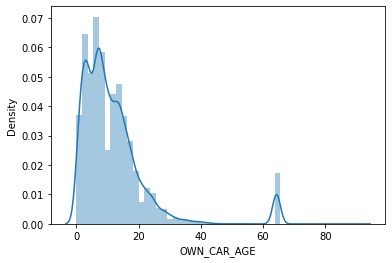

In [33]:
sns.distplot(dataset.OWN_CAR_AGE.dropna())

In [34]:
dataset.OWN_CAR_AGE = dataset.OWN_CAR_AGE.fillna(dataset.OWN_CAR_AGE.median()) # is median correct for no owned cars?

In [35]:
#Two of the external sources are also missing significant chunks of data. Of these, there are 179 values for which none of the three sources report any score, we will impute these by using the mean. For the others, we will impute the values for the missing data using the values in the other source(s).

In [36]:
# Missing EXT_SOURCE_N, 179 missing values
score_means = {i : dataset['EXT_SOURCE_' + i].mean() for i in ['1', '2', '3']} # save current means to use for later imputation
score_stds = {i : dataset['EXT_SOURCE_' + i].std() for i in ['1', '2', '3']}

for i in ['1', '2', '3']:
    dataset['EXT_SOURCE_' + i + '_ZSCORE'] = (dataset['EXT_SOURCE_' + i] - score_means[i])/score_stds[i]
dataset['EXT_SOURCE_ZAVE'] = dataset[['EXT_SOURCE_' + i + '_ZSCORE' for i in ['1', '2', '3']]].mean(axis = 1, skipna = True)
dataset.EXT_SOURCE_ZAVE = dataset.EXT_SOURCE_ZAVE.fillna(0)
for i in ['1', '2', '3']:
    dataset.loc[dataset['EXT_SOURCE_' + i].isnull(), 'EXT_SOURCE_' + i] = dataset[dataset['EXT_SOURCE_' + i].isnull()].EXT_SOURCE_ZAVE.map(lambda x: x*score_stds[i] + score_means[i])
dataset = dataset.drop(columns = ['EXT_SOURCE_' + i + '_ZSCORE' for i in ['1', '2', '3']] + ['EXT_SOURCE_ZAVE'])

In [37]:
#The two entries with missing family members list their number of children as 0 and their family (civil?) status as Unknown. We may reasonably assume that they're single and put the size of their family as 1. We edit the entries in the dataframe directly because there are only 2 rows to change (and thus no need to access and change the whole column) and we will also change the Unkown family status to single.

In [38]:
for i in [148605, 317181]:
    dataset.loc[dataset.SK_ID_CURR == i, 'CNT_FAM_MEMBERS'] = 1
    dataset.loc[dataset.SK_ID_CURR == i, 'NAME_FAMILY_STATUS'] = 'Single / not married'

In [39]:
# 36 missing annuity amounts (what precisely is meant by this), impute using median
dataset.AMT_ANNUITY = dataset.AMT_ANNUITY.fillna(dataset.AMT_ANNUITY.median())

# 278 missing amt goods price, impute using median
dataset.AMT_GOODS_PRICE = dataset.AMT_GOODS_PRICE.fillna(dataset.AMT_GOODS_PRICE.median())

# 4 missing social circle variables, 1050 missing values impute using median values, all of which are 0.
for i in ['OBS_30', 'DEF_30', 'OBS_60', 'DEF_60']:
    dataset[i+'_CNT_SOCIAL_CIRCLE'] = dataset[i+'_CNT_SOCIAL_CIRCLE'].fillna(0)

In [40]:
#Some columns like OCCUPATION_TYPE are missing a significant chunk of data and there are no real ways to fill in this missing data.

In [41]:
dataset[dataset.OCCUPATION_TYPE.isnull()].NAME_INCOME_TYPE.value_counts()

Pensioner               64630
Working                 28738
Commercial associate    14223
State servant            4373
Unemployed                 23
Student                     5
Businessman                 3
Maternity leave             1
Name: NAME_INCOME_TYPE, dtype: int64

In [42]:
dataset[(dataset.NAME_INCOME_TYPE == 'Pensioner') & (dataset.OCCUPATION_TYPE.notnull())].OCCUPATION_TYPE

106630          Laborers
113694    Medicine staff
134327    Cleaning staff
242307    Cleaning staff
274863       Sales staff
Name: OCCUPATION_TYPE, dtype: object

In [43]:
#The missing data does not seem to show any clear patterns that we could use to impute the missing values either. We see above the occupation types of the five pensioners whose occupation types are not missing. It is unclear whether this means that these pensioners are working in these occupations on top of collecting pensions (and that the others are simply not working) or not.

#It is even more difficult to impute the occupation types of the 28,000 working applicants whose occupations are not listed. Filling these columns in with data may introduce more noise and work against us, so we will drop them instead.

In [44]:
dataset = dataset.drop(columns = ['OCCUPATION_TYPE'])

In [45]:
## Data Encoding

In [46]:
categorical_columns = ['NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 
                       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
                       'HOUR_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'HOUSETYPE_MODE', 'FONDKAPREMONT_MODE',
                       'WALLSMATERIAL_MODE', 'NAME_CONTRACT_TYPE']

boolean_columns = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'EMERGENCYSTATE_MODE']

In [47]:
#This bit here needs to be updated because of changes to how sklearn does one hot encoding

In [48]:
from sklearn.preprocessing import OneHotEncoder
# dataset.loc[:, categorical_columns + boolean_columns] = (
#     dataset[categorical_columns + boolean_columns].apply(LabelEncoder().fit_transform)
# )
# # incorrect use of labelencoder!

# categorical encoder is not dataframe aware, so we must split the dataset into train and test
# before applying the categorical encoder

majority = dataset[dataset.TARGET==0].drop(columns=['TARGET'])
minority = dataset[dataset.TARGET==1].drop(columns=['TARGET'])
test_set = dataset[dataset.TARGET.isnull()].drop(columns=['TARGET'])
train_labels = dataset[dataset.TARGET.notnull()].TARGET

index_list = list(majority.columns) #not dataset because dataset has TARGET
categorical_indices = [index_list.index(col_name) for col_name in categorical_columns]
one_hot = OneHotEncoder(drop='if_binary', handle_unknown='ignore')

#for scikit-learn 0.20 and higher, use this:
from sklearn.compose import ColumnTransformer 
column_transformer = ColumnTransformer([('categorical', one_hot, categorical_columns + boolean_columns)], 
                                      remainder = 'passthrough', n_jobs = -1)

majority = column_transformer.fit_transform(majority)
minority = column_transformer.transform(minority)
test_set = column_transformer.transform(test_set)

In [49]:
from sklearn.model_selection import train_test_split
minority_train, minority_test = train_test_split(minority, test_size = 0.2)
majority_train, majority_test = train_test_split(majority, test_size = 0.2)
# this leaves 19860 lines in our minority train data

In [50]:
btrain = np.append(majority_train, minority_train, axis = 0)
btest = np.append(majority_test, minority_test, axis = 0)
btrain_labels = np.append(np.zeros(majority_train.shape[0]), np.ones(minority_train.shape[0]), axis = 0)
btest_labels = np.append(np.zeros(majority_test.shape[0]), np.ones(minority_test.shape[0]), axis = 0)

from sklearn.ensemble import RandomForestClassifier
model0 = RandomForestClassifier(n_estimators = 100, n_jobs = -1, max_features = 17) #17^2 = 289, total features is 281
model0.fit(btrain, btrain_labels)
bpred = model0.predict(btest)

In [51]:
from sklearn.metrics import f1_score
f1_score(btest_labels, bpred)

0.0008036970062286518

In [52]:
from sklearn.model_selection import ShuffleSplit, RepeatedKFold, KFold
undersampler = ShuffleSplit(n_splits = 10, test_size = 22500) 
downsampler = ShuffleSplit(n_splits = 10, test_size = 70000) 

In [53]:
model = RandomForestClassifier(n_estimators = 100, n_jobs = -1, max_features = 17) #same model as before...

cv = []
# balanced undersampling
majority_splitter = KFold(n_splits = 10).split(majority)
minority_splitter = KFold(n_splits = 10).split(minority)
i = 0
while i < 10: # a while loop allows us to call next on the two generators
    #split data into train and test
    split = next(majority_splitter)
    majority_train = majority[split[0]]
    majority_test = majority[split[1]]
    split = next(minority_splitter)
    minority_train = minority[split[0]]
    minority_test = minority[split[1]]
    
    # build test data    
    test_data = np.append(majority_test, minority_test, axis = 0)
    test_labels = np.append(np.zeros(majority_test.shape[0]), np.ones(minority_test.shape[0]), axis = 0)

    temp, train_indices = next(undersampler.split(majority_train))
    #merge the majority and minority data
    train_data = np.append(majority_train[train_indices], minority_train, axis = 0)
    train_labels = np.append(np.zeros(majority_train[train_indices].shape[0]), np.ones(minority_train.shape[0]), axis = 0)
    
    #fit the model and predict
    model.fit(train_data, train_labels)
    predicted_labels = model.predict(test_data)
    
    #score:
    cv.append(f1_score(test_labels, predicted_labels))
    
    #loop iterator
    i += 1
    
one_undersampling = pd.Series(cv)
one_undersampling.mean(), one_undersampling.std()

(0.26000503730297486, 0.0033068452949945046)

In [54]:
#0.26 F1 score is much better than before, but still not very good. Can we do better? Let's try imbalanced downsampling instead of undersampling.

In [55]:
cv = []
#single estimator imbalanced downsampling
majority_splitter = KFold(n_splits = 10).split(majority)
minority_splitter = KFold(n_splits = 10).split(minority)
i = 0
while i < 10: # a while loop allows us to call next on the two generators
    #split data into train and test
    split = next(majority_splitter)
    majority_train = majority[split[0]]
    majority_test = majority[split[1]]
    split = next(minority_splitter)
    minority_train = minority[split[0]]
    minority_test = minority[split[1]]
    
    # build test data    
    test_data = np.append(majority_test, minority_test, axis = 0)
    test_labels = np.append(np.zeros(majority_test.shape[0]), np.ones(minority_test.shape[0]), axis = 0)

    temp, train_indices = next(downsampler.split(majority_train))
    #merge the majority and minority data
    train_data = np.append(majority_train[train_indices], minority_train, axis = 0)
    train_labels = np.append(np.zeros(majority_train[train_indices].shape[0]), np.ones(minority_train.shape[0]), axis = 0)

    #fit the model and predict
    model.fit(train_data, train_labels)
    predicted_labels = model.predict(test_data)

    #score
    cv.append(f1_score(test_labels, predicted_labels))
    
    #loop iterator
    i += 1
    
one_downsampling = pd.Series(cv)
one_downsampling.mean(), one_downsampling.std()

(0.20886216323780124, 0.008677657545862364)

In [56]:
#This gives us 0.2086 F1 score.

#Let's try some enseble methods. But first, a function to reduce code redundancy

In [58]:
def model_cv(model, imbalance, sampling, ensemble, cv = 10, eval_metric = f1_score):
    # imabalnce method: 'under' or 'down'
    # sampling methods: 'kfold', 'shuffle'
    # ensemble methods: 'vote' or 'proba'
    # eval_metric: callable, takes y_true, y_pred and returns score
    
    cv_scores = []    
    majority_splitter = KFold(n_splits = cv).split(majority)
    minority_splitter = KFold(n_splits = cv).split(minority)
    i = 0
    while i < 10: # a while loop allows us to call next on the two generators
        #split data into train and test
        split = next(majority_splitter)
        majority_train = majority[split[0]]
        majority_test = majority[split[1]]
        split = next(minority_splitter)
        minority_train = minority[split[0]]
        minority_test = minority[split[1]]
        
        #sampler
        if imbalance == 'under':
            ratio = 1
        elif imbalance == 'down':
            ratio = 3
        if sampling == 'kfold':
            sample_ratio = int(majority_train.shape[0]/(ratio*minority_train.shape[0]))
            sampler = KFold(n_splits = sample_ratio, shuffle = True)
        elif sampling == 'shuffle':
            sampler = ShuffleSplit(n_splits = 10, test_size = ratio*minority_train.shape[0])

        #build test data and labels
        test_data = np.append(majority_test, minority_test, axis = 0)
        test_labels = np.append(np.zeros(majority_test.shape[0]), np.ones(minority_test.shape[0]), axis = 0)

        predicted_labels = pd.DataFrame()
        #sampling the split data
        for temp, train_indices in sampler.split(majority_train):
            #build training data
            train_data = np.append(majority_train[train_indices], minority_train, axis = 0)
            train_labels = np.append(np.zeros(majority_train[train_indices].shape[0]), 
                                     np.ones(minority_train.shape[0]), axis = 0)

            #model fit and predict
            model.fit(train_data, train_labels)
            if ensemble == 'vote':
                predicted_labels[str(i)] = model.predict(test_data)
            elif ensemble == 'proba':
                predicted_labels[str(i)] = model.predict_proba(test_data)[:, 1].reshape(-1)
        #ensemble
        if ensemble == 'vote':
            predicted_labels = predicted_labels.mode(axis = 1).values
        elif ensemble == 'proba':
            predicted_labels = predicted_labels.mean(axis = 1).map(lambda x: 1 if x > 0.5 else 0).values

        #score
        cv_scores.append(eval_metric(test_labels, predicted_labels))

        #loop iterator
        i += 1
    return cv_scores

In [59]:
model = RandomForestClassifier(n_estimators = 100, n_jobs = -1) #same model as before...
#balanced undersampling without replacement aggregation using probabilities
cv_scores = model_cv(model, 'under', 'kfold', 'proba')
multiple_undersampling = pd.Series(cv)
multiple_undersampling.mean(), multiple_undersampling.std()

(0.20886216323780124, 0.008677657545862364)

In [60]:
#Now trying balanced undersampling with replacement aggregation using probabilities

In [61]:
# balanced undersampling with replacement aggregation using probabilities
cv_scores = model_cv(model, 'under', 'shuffle', 'proba')
multiple_undersampling_r = pd.Series(cv)
multiple_undersampling_r.mean(), multiple_undersampling_r.std()

(0.20886216323780124, 0.008677657545862364)

In [62]:
#Now let's try ensemble learning with imbalanced downsampling with and without replacement aggregation

In [63]:
#imbalanced downsampling without replacement aggregation using probabilities
cv_scores = model_cv(model, 'down', 'kfold', 'vote')
multiple_downsampling = pd.Series(cv)
multiple_downsampling.mean(), multiple_downsampling.std()

(0.20886216323780124, 0.008677657545862364)

In [64]:
#imbalanced downsampling with replacement aggregation using probabilities
cv_scores = model_cv(model, 'down', 'shuffle', 'proba')
multiple_downsampling_r = pd.Series(cv)
multiple_downsampling_r.mean(), multiple_downsampling_r.std()

(0.20886216323780124, 0.008677657545862364)

In [65]:
#It seems that the ensemble models utilizing probabilities perform better than the ones using simple majority voting. It's also interesting to note that the performance when we use probabilistic voting is very similar, maybe we're getting slightly different models that achieve a result that is almost exactly the same.

#Let's try xgboost...

In [66]:
from xgboost.sklearn import XGBClassifier

model = XGBClassifier(n_jobs = 4)

def xgb_f1(y_pred, y_true):
    y_true = y_true.get_label()
    return 'f1', f1_score(y_true, y_pred)

majority_splitter = KFold(n_splits = 10).split(majority)
minority_splitter = KFold(n_splits = 10).split(minority)
i = 0
while i < 10: # a while loop allows us to call next on the two generators
    #split data into train and test
    split = next(majority_splitter)
    majority_train = majority[split[0]]
    majority_test = majority[split[1]]
    split = next(minority_splitter)
    minority_train = minority[split[0]]
    minority_test = minority[split[1]]
    
    # build test data    
    test_data = np.append(majority_test, minority_test, axis = 0)
    test_labels = np.append(np.zeros(majority_test.shape[0]), np.ones(minority_test.shape[0]), axis = 0)

    temp, train_indices = next(undersampler.split(majority_train))
    #merge the majority and minority data
    train_data = np.append(majority_train[train_indices], minority_train, axis = 0)
    train_labels = np.append(np.zeros(majority_train[train_indices].shape[0]), np.ones(minority_train.shape[0]), axis = 0)
    
    #fit the model and predict
    model.fit(train_data, train_labels, eval_metric = xgb_f1)
    predicted_labels = model.predict(test_data)
    
    #score:
    cv.append(f1_score(test_labels, predicted_labels))
    
    #loop iterator
    i += 1
xgb_under = pd.Series(cv)
xgb_under.mean(), xgb_under.std()

ModuleNotFoundError: No module named 'xgboost'